In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import gc
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

pd.set_option('max_columns', None)
pd.set_option('max_rows', None)
pd.set_option('max_colwidth', 200)

warnings.filterwarnings('ignore')
tqdm.pandas()

%matplotlib inline

### 用户表

In [2]:
train_user = pd.read_csv('../input/train/train_user.csv')
test_user = pd.read_csv('../input/test/test_user.csv')

In [3]:
train_user.head()

,phone_no_m,city_name,county_name,idcard_cnt,arpu_201908,arpu_201909,arpu_201910,arpu_201911,arpu_201912,arpu_202001,arpu_202002,arpu_202003,label
0,672ddbf02a5544d32e4ecc9433b1981bffe23bf912273a3a835f6cccb78b8ed7554e9ab0fbcd33d19eb6063ce00542dd223cc5cc83c68f07bcf933547b6776b1,绵阳,江油分公司,1,46.06,45.00,45.0,45.00,45.00,45.0,45.0,45.0,0
1,5e1272273e041e82cb275ae877710be98cdaf5b0a8f34de8d361f71d5268fa0851edffd3950e170df1e3846fcf90cc7cc8299be9139a2ac4b5c5e5121d832674,德阳,旌阳分公司,1,79.00,79.20,79.1,79.30,41.40,34.1,59.4,60.0,0
2,eaab3472ec87b076e69e6e8bb62b14341638fc63661a6c682d6add360a4332a8ad294d8470d64a73c6e53e8413f0ad93b9ea65afab717e58d312554f33553ee7,成都,金堂分公司,2,18.85,24.45,22.0,21.40,22.15,21.1,61.3,63.0,0
3,0ce1bb415704178bf44e9c9b431a39b083a132c8e6d99f3627cd4520064b93ec66a72d085a67f0f40eebb9f901072965073e398f04c4ae500a1db4dfb13a972c,成都,高新分公司,2,19.20,29.65,130.4,173.12,19.00,19.0,19.0,23.2,0
4,28b87f35f63f65096a53e3a4c97eaffd4a6c43ffa7e92d7706b20520aa11fff0f4ce06203f66758ec0f0e70780e4e258aae6aa1f23439e115528e08eda71ed20,德阳,旌阳分公司,1,50.00,50.00,50.0,50.00,50.00,50.0,50.0,50.0,0


In [4]:
test_user.head()

,phone_no_m,city_name,county_name,idcard_cnt,arpu_202004
0,22d522340df77e2252c1a4d92b4bcb00d515e36f3ec6bf94e017b4ffd67e26520af18637ad91bde69abd831cc36cdc0c5af5e57bc280f95f79efef7bfa9c6926,成都,金牛分公司,1,9.0
1,5220d4b8429bdba3971a7b46a088c6b8fa6710f40607598ac1219daab6071510b3f66f78637420574dbb2d5488d44de9d4360a644bbe4ec45aaa4b7513bdc886,天府新区,天府直属部门,1,NaN
2,7d19dd2b50ced56f03d23bf928cf34dc570a48525571a868ffdcdc53a865b7a41c386a6f1d6567dd4a710530b933308c77d1ef89f77b580d1983dadd3de162ea,成都,锦江分公司,1,9.0
3,134a4a591185c9d3788021896dcfc235e9e0a6a1e3f8a4fd3a9f9d9bf4a033e791b7199db980b0678020bdf689d719306a5c694ffa47b4ba2bec43ceda68dfc1,绵阳,江油分公司,1,138.7
4,2356dcd6759d50455ddaeed03c838843558e9182d5962f8a4c81a9a178063c49ab988750f795bb6c5462aee5dace2ad9fd18dbb1a6619dbb1e771e9b0f192da9,成都,青羊分公司,2,39.0


1. 查看训练集和测试集电话号码的交集

In [5]:
tr_u = set(list(train_user['phone_no_m'].unique()))
te_u = set(list(test_user['phone_no_m'].unique()))

tr_u & te_u

set()

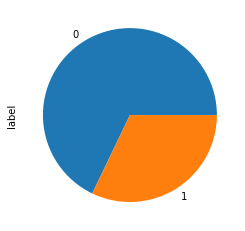

In [6]:
_ = train_user.label.value_counts().plot.pie()

In [7]:
train_user.shape, test_user.shape

((6106, 13), (2045, 5))

In [8]:
# 训练集只取最后一个月的数据
train_user['arpu_202004'] = train_user['arpu_202003']

train_user.drop(['arpu_201908', 'arpu_201909', 'arpu_201910', 'arpu_201911',
                 'arpu_201912', 'arpu_202001', 'arpu_202002', 'arpu_202003'],
                axis=1,
                inplace=True)
train_user.head()

,phone_no_m,city_name,county_name,idcard_cnt,label,arpu_202004
0,672ddbf02a5544d32e4ecc9433b1981bffe23bf912273a3a835f6cccb78b8ed7554e9ab0fbcd33d19eb6063ce00542dd223cc5cc83c68f07bcf933547b6776b1,绵阳,江油分公司,1,0,45.0
1,5e1272273e041e82cb275ae877710be98cdaf5b0a8f34de8d361f71d5268fa0851edffd3950e170df1e3846fcf90cc7cc8299be9139a2ac4b5c5e5121d832674,德阳,旌阳分公司,1,0,60.0
2,eaab3472ec87b076e69e6e8bb62b14341638fc63661a6c682d6add360a4332a8ad294d8470d64a73c6e53e8413f0ad93b9ea65afab717e58d312554f33553ee7,成都,金堂分公司,2,0,63.0
3,0ce1bb415704178bf44e9c9b431a39b083a132c8e6d99f3627cd4520064b93ec66a72d085a67f0f40eebb9f901072965073e398f04c4ae500a1db4dfb13a972c,成都,高新分公司,2,0,23.2
4,28b87f35f63f65096a53e3a4c97eaffd4a6c43ffa7e92d7706b20520aa11fff0f4ce06203f66758ec0f0e70780e4e258aae6aa1f23439e115528e08eda71ed20,德阳,旌阳分公司,1,0,50.0


In [9]:
train_user['cents'] = (train_user['arpu_202004'] - np.floor(train_user['arpu_202004'])).astype('float32')
test_user['cents'] = (test_user['arpu_202004'] - np.floor(test_user['arpu_202004'])).astype('float32')

#### LabelEncoder

In [10]:
lbl = LabelEncoder()

df_user = pd.concat([train_user, test_user], axis=0, ignore_index=True)

for f in tqdm(['city_name', 'county_name']):
    df_user[f] = df_user[f].fillna('NA')
    df_user[f] = lbl.fit_transform(df_user[f].astype(str))
    
df_user.head()

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 222.78it/s]


,phone_no_m,city_name,county_name,idcard_cnt,label,arpu_202004,cents
0,672ddbf02a5544d32e4ecc9433b1981bffe23bf912273a3a835f6cccb78b8ed7554e9ab0fbcd33d19eb6063ce00542dd223cc5cc83c68f07bcf933547b6776b1,16,97,1,0.0,45.0,0.0
1,5e1272273e041e82cb275ae877710be98cdaf5b0a8f34de8d361f71d5268fa0851edffd3950e170df1e3846fcf90cc7cc8299be9139a2ac4b5c5e5121d832674,10,82,1,0.0,60.0,0.0
2,eaab3472ec87b076e69e6e8bb62b14341638fc63661a6c682d6add360a4332a8ad294d8470d64a73c6e53e8413f0ad93b9ea65afab717e58d312554f33553ee7,11,160,2,0.0,63.0,0.0
3,0ce1bb415704178bf44e9c9b431a39b083a132c8e6d99f3627cd4520064b93ec66a72d085a67f0f40eebb9f901072965073e398f04c4ae500a1db4dfb13a972c,11,181,2,0.0,23.2,0.2
4,28b87f35f63f65096a53e3a4c97eaffd4a6c43ffa7e92d7706b20520aa11fff0f4ce06203f66758ec0f0e70780e4e258aae6aa1f23439e115528e08eda71ed20,10,82,1,0.0,50.0,0.0


### 通话表

In [11]:
train_voc = pd.read_csv('../input/train/train_voc.csv')
test_voc = pd.read_csv('../input/test/test_voc.csv')

train_voc['start_datetime'] = train_voc['start_datetime'].astype('datetime64')
test_voc['start_datetime'] = test_voc['start_datetime'].astype('datetime64')

In [12]:
train_voc.head()

,phone_no_m,opposite_no_m,calltype_id,start_datetime,call_dur,city_name,county_name,imei_m
0,3b6bef554a4754fa9977b50d99e6777c9fb26e585961a453bab3a2eba9f25eb510376bb89a345fb1a073e3a99da296d0f3c40aec8d0b4efd159eae4acb46f3c8,3572f19c52faeea5111ddd79dfc3643171d00e6d8b3fd9d6d04701a1873702a50004019f70d8a4c766d24e7768d356f6420ca28e27a7b0343f0acf3116655a58,2,2019-10-17 17:16:25,13,NaN,NaN,d2940d7cde5092d809af2e4bb8f6936a405382bd541542c5ccbb9d577d7d340ea032cca1174d33cca05393fbfd45fc0715198781d726679a09db74dac778c9c5
1,3b6bef554a4754fa9977b50d99e6777c9fb26e585961a453bab3a2eba9f25eb510376bb89a345fb1a073e3a99da296d0f3c40aec8d0b4efd159eae4acb46f3c8,3572f19c52faeea5111ddd79dfc3643171d00e6d8b3fd9d6d04701a1873702a50004019f70d8a4c766d24e7768d356f6420ca28e27a7b0343f0acf3116655a58,2,2019-10-17 17:36:20,16,NaN,NaN,d2940d7cde5092d809af2e4bb8f6936a405382bd541542c5ccbb9d577d7d340ea032cca1174d33cca05393fbfd45fc0715198781d726679a09db74dac778c9c5
2,ecd1b3f5a38576ef9872d1cb7a762f31869153de736e7aa43742ebd2ce6ffac1e6be304c79819a8f3770c1546b11f779be225ff0d0a18eb02f29ca4ef2c964ce,c386d11d5203136e924e070afcac734cdaea6691472e841fe981d839abdb7c9ad794024c7c484b86d5cf5553a1531079a1a3e3ec1e932cea62293d0d04eb13b7,1,2019-08-28 09:46:50,18,NaN,NaN,071e8dcb4010c643c48339cb8abf4a69e03b37afade98ded48ae19b2dafe965f5b28299131441a068b066588492389a3e66c3105f3cd5ab8c3eefff0015373f5
3,41a97bdfe77f3210deba78689baecb110922878be2f14c2b17416d04da12fe75fe3ecd80de2be43f5f2615557640e588d08b81d504d73f25aa7a40726d3acf4d,79ef199a532bcb9a89990d0996cee3d40557f06b9e5265fee8357eaca7735ec4ed65670d446c09482c535bd4eb1e3e07c5bd49704e49b50958b2e54c34f29a7b,1,2019-09-18 16:19:20,34,NaN,NaN,5f054945a5037e688abe0ef36d88a0fd351d476e3320c22cb3da7692d4ba4ba3e7752253ef74c6af1763089b830687d06535dfc6ba4f411196889364868425af
4,41a97bdfe77f3210deba78689baecb110922878be2f14c2b17416d04da12fe75fe3ecd80de2be43f5f2615557640e588d08b81d504d73f25aa7a40726d3acf4d,e273542129cf7fa37c28d3f4c95b7b9e8bcb561bbabc50063a1a5a1fd133a14f62f8a59649e5dffacccdb661300a7ef5aaea710b8a1155c4904647d9d5877e49,2,2019-09-18 16:18:46,23,NaN,NaN,5f054945a5037e688abe0ef36d88a0fd351d476e3320c22cb3da7692d4ba4ba3e7752253ef74c6af1763089b830687d06535dfc6ba4f411196889364868425af


In [13]:
# 同样只取最后一个月的数据

train_voc = train_voc[train_voc['start_datetime'] >= '2020-03-01 00:00:00']
train_voc = train_voc.reset_index(drop=True)

df_voc = pd.concat([train_voc, test_voc])

In [14]:
# 时间切割

df_voc['voc_day'] = df_voc['start_datetime'].dt.day
df_voc['voc_hour'] = df_voc['start_datetime'].dt.hour
# df_voc['voc_ts'] = pd.to_timedelta(df_voc['start_datetime'], unit='ns').dt.total_seconds().astype(int)

# df_voc = df_voc.sort_values(by='voc_ts').reset_index(drop=True)

In [15]:
# 一天内通话统计量

df_voc['voc_day_count'] = df_voc.groupby(['phone_no_m', 'voc_day'])['phone_no_m'].transform('count')
df_voc['voc_day_count_max'] = df_voc.groupby('phone_no_m')['voc_day_count'].transform('max')
df_voc['voc_day_count_min'] = df_voc.groupby('phone_no_m')['voc_day_count'].transform('min')
df_voc['voc_day_count_mean'] = df_voc.groupby('phone_no_m')['voc_day_count'].transform('mean')
df_voc['voc_day_count_std'] = df_voc.groupby('phone_no_m')['voc_day_count'].transform('std')

del df_voc['voc_day_count']

In [16]:
# 一小时内通话统计量

df_voc['voc_hour_count'] = df_voc.groupby(['phone_no_m', 'voc_hour'])['phone_no_m'].transform('count')
df_voc['voc_hour_count_max'] = df_voc.groupby('phone_no_m')['voc_hour_count'].transform('max')
df_voc['voc_hour_count_min'] = df_voc.groupby('phone_no_m')['voc_hour_count'].transform('min')
df_voc['voc_hour_count_mean'] = df_voc.groupby('phone_no_m')['voc_hour_count'].transform('mean')
df_voc['voc_hour_count_std'] = df_voc.groupby('phone_no_m')['voc_hour_count'].transform('std')

del df_voc['voc_hour_count']

In [17]:
# 总量

df_voc['voc_count'] = df_voc.groupby('phone_no_m')['phone_no_m'].transform('count')

In [18]:
df_voc.head()

,phone_no_m,opposite_no_m,calltype_id,start_datetime,call_dur,city_name,county_name,imei_m,voc_day,voc_hour,voc_day_count_max,voc_day_count_min,voc_day_count_mean,voc_day_count_std,voc_hour_count_max,voc_hour_count_min,voc_hour_count_mean,voc_hour_count_std,voc_count
0,b3994b4c46e39954cfe0cb8ebd2a79703a2ace6612fa18241509e8b2dfe9d75f503823b6df2d10180a9033ccd22390aaeda397037ca4cd26604d6db6e3470874,1b01124a6ad0443ad868757c6594a605a0c5179c2b5b57071d5cec8cd8c4c89d7598587f953f08887965b42d2e465d08388c5465fe43b67f1e9ca5509c5529f2,1,2020-03-22 21:38:40,175,NaN,NaN,90ba61111dad175330029e10da8264a86dfdb3a281ccb8556eca87a6f1af32e1d5ff4db4a7d4b11f760e4866de974933f247c4c389073f28634229889bfe18bf,22,21,9,1,6.248000,2.415194,14,1,8.728000,3.216329,125
1,b3994b4c46e39954cfe0cb8ebd2a79703a2ace6612fa18241509e8b2dfe9d75f503823b6df2d10180a9033ccd22390aaeda397037ca4cd26604d6db6e3470874,1b01124a6ad0443ad868757c6594a605a0c5179c2b5b57071d5cec8cd8c4c89d7598587f953f08887965b42d2e465d08388c5465fe43b67f1e9ca5509c5529f2,1,2020-03-23 18:05:41,33,NaN,NaN,90ba61111dad175330029e10da8264a86dfdb3a281ccb8556eca87a6f1af32e1d5ff4db4a7d4b11f760e4866de974933f247c4c389073f28634229889bfe18bf,23,18,9,1,6.248000,2.415194,14,1,8.728000,3.216329,125
2,c5502a6d3e4cabaf8c0e298c4aac693b6e80835d50d4e4f393d8426bd49c0d4d00c3959d2a2c8341410e57af28bee6dc5c80dbad7cf147018ec0ece7bfa0cf5f,f1b73c46a691c068bfd38253e20e882d4993c8d3e58016aeed804a8cdbf54542112e529ebf7fdd0e62cf3556571fb17b865d8c3d57c42be851d75c90f4df4603,1,2020-03-01 11:24:37,39,NaN,NaN,e1e1149b2c06e9972293c457293abb32ad05b0c82b3b64c3786896b0414c897b60a539329ce3b7df83ebee19ad20fee3971303edd776a593578f03d16ee8981a,1,11,5,1,2.500000,1.638356,5,1,2.800000,1.399248,20
3,c5502a6d3e4cabaf8c0e298c4aac693b6e80835d50d4e4f393d8426bd49c0d4d00c3959d2a2c8341410e57af28bee6dc5c80dbad7cf147018ec0ece7bfa0cf5f,5bc6d97a3017578edfa7979fa43653cd74bad827f18337c8c84728f79778939b6f939ea3aa2661907f2e79bcf70feb93adb79c3f7d4a934368c459d9b6aeb54e,1,2020-03-01 11:23:44,32,NaN,NaN,e1e1149b2c06e9972293c457293abb32ad05b0c82b3b64c3786896b0414c897b60a539329ce3b7df83ebee19ad20fee3971303edd776a593578f03d16ee8981a,1,11,5,1,2.500000,1.638356,5,1,2.800000,1.399248,20
4,2bdbc0a45d6228970b353d691e2ec229f0cf60790a1a39d5e01c0175b5e20cd2ca7d39aff8506741884fd7a4cd4fd9fdec5112ddb764d81c2983752c989f1078,c42eeddeff98feb87860441ea6548f8bda2a080c935e02c7a6ae30223cf37dfc2d16760224c79b93ea44a6d3fd77139e03a20f47608b9455372a96cb026f239e,2,2020-03-03 15:34:21,3,NaN,NaN,3e808a14fa2aa61524c70f262539d1c8532b8e3a8c7c87c863b3f8420750f1bf4a63aa900aef09620c1fae1a6a7fadf1f42e30477e24336fc5c2a8fae9b5de6e,3,15,10,1,5.051282,2.997390,12,1,6.820513,2.996724,78


### 短信表

In [19]:
train_sms = pd.read_csv('../input/train/train_sms.csv')
test_sms = pd.read_csv('../input/test/test_sms.csv')

train_sms['request_datetime'] = train_sms['request_datetime'].astype('datetime64')
test_sms['request_datetime'] = test_sms['request_datetime'].astype('datetime64')

In [20]:
# 同样只取最后一个月的数据

train_sms = train_sms[train_sms['request_datetime'] >= '2020-03-01 00:00:00']
train_sms = train_sms.reset_index(drop=True)

df_sms = pd.concat([train_sms, test_sms])

In [21]:
# 时间切割

df_sms['sms_day'] = df_sms['request_datetime'].dt.day
df_sms['sms_hour'] = df_sms['request_datetime'].dt.hour
# df_sms['sms_ts'] = pd.to_timedelta(df_sms['request_datetime'], unit='ns').dt.total_seconds().astype(int)

# df_sms = df_sms.sort_values(by='sms_ts').reset_index(drop=True)

In [22]:
# 一天内短信统计量

df_sms['sms_day_count'] = df_sms.groupby(['phone_no_m', 'sms_day'])['phone_no_m'].transform('count')
df_sms['sms_day_count_max'] = df_sms.groupby('phone_no_m')['sms_day_count'].transform('max')
df_sms['sms_day_count_min'] = df_sms.groupby('phone_no_m')['sms_day_count'].transform('min')
df_sms['sms_day_count_mean'] = df_sms.groupby('phone_no_m')['sms_day_count'].transform('mean')
df_sms['sms_day_count_std'] = df_sms.groupby('phone_no_m')['sms_day_count'].transform('std')

del df_sms['sms_day_count']

In [23]:
# 一小时内短信统计量

df_sms['sms_hour_count'] = df_sms.groupby(['phone_no_m', 'sms_hour'])['phone_no_m'].transform('count')
df_sms['sms_hour_count_max'] = df_sms.groupby('phone_no_m')['sms_hour_count'].transform('max')
df_sms['sms_hour_count_min'] = df_sms.groupby('phone_no_m')['sms_hour_count'].transform('min')
df_sms['sms_hour_count_mean'] = df_sms.groupby('phone_no_m')['sms_hour_count'].transform('mean')
df_sms['sms_hour_count_std'] = df_sms.groupby('phone_no_m')['sms_hour_count'].transform('std')

del df_sms['sms_hour_count']

In [24]:
# 总量

df_sms['sms_count'] = df_sms.groupby('phone_no_m')['phone_no_m'].transform('count')

In [25]:
df_sms.head()

,phone_no_m,opposite_no_m,calltype_id,request_datetime,sms_day,sms_hour,sms_day_count_max,sms_day_count_min,sms_day_count_mean,sms_day_count_std,sms_hour_count_max,sms_hour_count_min,sms_hour_count_mean,sms_hour_count_std,sms_count
0,3c4adabd6c1eb2774054cdc67e8d1df09f89f4fd0b44fa0dfdb973c61688d8eb527ca71cd08d9006085c4d4888d4f9427210b4b5787dbe3d579550c3cd22aeeb,df22edbc0e3dd6bc4f2f453e687b743e8442a54834b64f06ee093a91c4a41385d46579107a443eee3ec0ce2339bcea4152a996ca8cf0b2cc846eb2acc9cc241b,2,2020-03-01 10:19:12,1,10,7,1,3.50000,1.708801,16,1,9.763158,4.743749,76
1,3c4adabd6c1eb2774054cdc67e8d1df09f89f4fd0b44fa0dfdb973c61688d8eb527ca71cd08d9006085c4d4888d4f9427210b4b5787dbe3d579550c3cd22aeeb,df22edbc0e3dd6bc4f2f453e687b743e8442a54834b64f06ee093a91c4a41385d46579107a443eee3ec0ce2339bcea4152a996ca8cf0b2cc846eb2acc9cc241b,2,2020-03-01 10:19:12,1,10,7,1,3.50000,1.708801,16,1,9.763158,4.743749,76
2,e531a69afd185e0e97fb35fd7caa0f5e2e4efc4a1c80f75d81ebb2b99288250074964ae0f9360670038065d3f4f6d7fe7d7a760bca776fd842bc187ea3543373,df22edbc0e3dd6bc4f2f453e687b743e8442a54834b64f06ee093a91c4a41385d46579107a443eee3ec0ce2339bcea4152a996ca8cf0b2cc846eb2acc9cc241b,2,2020-03-01 14:29:26,1,14,57,7,23.28169,12.928710,60,1,38.211268,14.447414,568
3,e531a69afd185e0e97fb35fd7caa0f5e2e4efc4a1c80f75d81ebb2b99288250074964ae0f9360670038065d3f4f6d7fe7d7a760bca776fd842bc187ea3543373,df22edbc0e3dd6bc4f2f453e687b743e8442a54834b64f06ee093a91c4a41385d46579107a443eee3ec0ce2339bcea4152a996ca8cf0b2cc846eb2acc9cc241b,2,2020-03-01 14:29:26,1,14,57,7,23.28169,12.928710,60,1,38.211268,14.447414,568
4,e531a69afd185e0e97fb35fd7caa0f5e2e4efc4a1c80f75d81ebb2b99288250074964ae0f9360670038065d3f4f6d7fe7d7a760bca776fd842bc187ea3543373,df22edbc0e3dd6bc4f2f453e687b743e8442a54834b64f06ee093a91c4a41385d46579107a443eee3ec0ce2339bcea4152a996ca8cf0b2cc846eb2acc9cc241b,2,2020-03-01 14:29:26,1,14,57,7,23.28169,12.928710,60,1,38.211268,14.447414,568


### 应用表

In [26]:
train_app = pd.read_csv('../input/train/train_app.csv')
test_app = pd.read_csv('../input/test/test_app.csv')

In [27]:
# 同样只取最后一个月

train_app = train_app[train_app['month_id'] == '2020-03']
train_app = train_app.reset_index(drop=True)

df_app = pd.concat([train_app, test_app])

In [28]:
# 流量统计

df_app['total_flow'] = df_app.groupby('phone_no_m')['flow'].transform('sum')
df_app['flow_max'] = df_app.groupby('phone_no_m')['flow'].transform('max')
df_app['flow_min'] = df_app.groupby('phone_no_m')['flow'].transform('min')
df_app['flow_mean'] = df_app.groupby('phone_no_m')['flow'].transform('mean')
df_app['flow_std'] = df_app.groupby('phone_no_m')['flow'].transform('std')

# 应用数
df_app['app_count'] = df_app.groupby('phone_no_m')['phone_no_m'].transform('count')

In [29]:
df_app.head()

,phone_no_m,busi_name,flow,month_id,total_flow,flow_max,flow_min,flow_mean,flow_std,app_count
0,229a0f324de3c54b4cc4c82dafbf78ee5874fe491e4d9a5a44c16f243922f1884e84ce9a910dfee5be7b1f8b2ae2784cc6ee1f65222f841a84acef2b1f11cac2,NaN,125.060604,2020-03,5189.21207,2000.995233,0.00074,55.797979,250.141054,93
1,229a0f324de3c54b4cc4c82dafbf78ee5874fe491e4d9a5a44c16f243922f1884e84ce9a910dfee5be7b1f8b2ae2784cc6ee1f65222f841a84acef2b1f11cac2,QQ,7.247598,2020-03,5189.21207,2000.995233,0.00074,55.797979,250.141054,93
2,229a0f324de3c54b4cc4c82dafbf78ee5874fe491e4d9a5a44c16f243922f1884e84ce9a910dfee5be7b1f8b2ae2784cc6ee1f65222f841a84acef2b1f11cac2,旺信,0.008341,2020-03,5189.21207,2000.995233,0.00074,55.797979,250.141054,93
3,229a0f324de3c54b4cc4c82dafbf78ee5874fe491e4d9a5a44c16f243922f1884e84ce9a910dfee5be7b1f8b2ae2784cc6ee1f65222f841a84acef2b1f11cac2,微信,584.027821,2020-03,5189.21207,2000.995233,0.00074,55.797979,250.141054,93
4,229a0f324de3c54b4cc4c82dafbf78ee5874fe491e4d9a5a44c16f243922f1884e84ce9a910dfee5be7b1f8b2ae2784cc6ee1f65222f841a84acef2b1f11cac2,起点读书,5.342432,2020-03,5189.21207,2000.995233,0.00074,55.797979,250.141054,93


### 合并

In [30]:
df_user.shape, df_voc.shape, df_sms.shape, df_app.shape

((8151, 7), (985666, 19), (1319506, 15), (512100, 10))

In [31]:
df_voc = df_voc[['phone_no_m', 'calltype_id', 
                 'call_dur', 'voc_day', 'voc_hour',
                 'voc_day_count_max', 'voc_day_count_min', 'voc_day_count_mean', 'voc_day_count_std', 
                 'voc_hour_count_max', 'voc_hour_count_min', 'voc_hour_count_mean', 'voc_hour_count_std',
                 'voc_count']].drop_duplicates(subset=['phone_no_m'])

In [32]:
df_sms = df_sms[['phone_no_m', 'sms_day', 'sms_hour', 
                 'sms_day_count_max', 'sms_day_count_min', 'sms_day_count_mean', 'sms_day_count_std', 
                 'sms_hour_count_max', 'sms_hour_count_min', 'sms_hour_count_mean', 'sms_hour_count_std',
                 'sms_count']].drop_duplicates(subset=['phone_no_m'])

In [33]:
df_app = df_app[['phone_no_m', 'total_flow', 'flow_max', 'flow_min',
                 'flow_mean', 'flow_std', 'app_count']].drop_duplicates(subset=['phone_no_m'])

In [34]:
df = pd.merge(df_user, df_voc, how='left', on='phone_no_m')
df = pd.merge(df, df_sms, how='left', on='phone_no_m')
df = pd.merge(df, df_app, how='left', on='phone_no_m')

df.head()

,phone_no_m,city_name,county_name,idcard_cnt,label,arpu_202004,cents,calltype_id,call_dur,voc_day,voc_hour,voc_day_count_max,voc_day_count_min,voc_day_count_mean,voc_day_count_std,voc_hour_count_max,voc_hour_count_min,voc_hour_count_mean,voc_hour_count_std,voc_count,sms_day,sms_hour,sms_day_count_max,sms_day_count_min,sms_day_count_mean,sms_day_count_std,sms_hour_count_max,sms_hour_count_min,sms_hour_count_mean,sms_hour_count_std,sms_count,total_flow,flow_max,flow_min,flow_mean,flow_std,app_count
0,672ddbf02a5544d32e4ecc9433b1981bffe23bf912273a3a835f6cccb78b8ed7554e9ab0fbcd33d19eb6063ce00542dd223cc5cc83c68f07bcf933547b6776b1,16,97,1,0.0,45.0,0.0,1.0,31.0,17.0,17.0,12.0,1.0,4.971831,3.601475,11.0,1.0,6.042254,3.025778,71.0,11.0,3.0,16.0,1.0,7.089552,4.362283,24.0,1.0,12.059701,6.588622,134.0,168.124505,99.590643,0.000456,2.849568,13.173569,59.0
1,5e1272273e041e82cb275ae877710be98cdaf5b0a8f34de8d361f71d5268fa0851edffd3950e170df1e3846fcf90cc7cc8299be9139a2ac4b5c5e5121d832674,10,82,1,0.0,60.0,0.0,2.0,12.0,30.0,12.0,2.0,1.0,1.363636,0.504525,3.0,1.0,1.727273,0.904534,11.0,3.0,9.0,22.0,1.0,14.142857,4.892586,71.0,1.0,41.112045,23.306550,357.0,10088.555221,2537.237967,0.001075,53.662528,237.544176,188.0
2,eaab3472ec87b076e69e6e8bb62b14341638fc63661a6c682d6add360a4332a8ad294d8470d64a73c6e53e8413f0ad93b9ea65afab717e58d312554f33553ee7,11,160,2,0.0,63.0,0.0,2.0,34.0,9.0,17.0,25.0,1.0,11.151515,5.496608,36.0,1.0,22.818182,9.387167,264.0,7.0,17.0,32.0,3.0,12.783394,8.035024,44.0,1.0,25.397112,12.424601,277.0,357.531875,74.788056,0.000526,3.928922,12.155846,91.0
3,0ce1bb415704178bf44e9c9b431a39b083a132c8e6d99f3627cd4520064b93ec66a72d085a67f0f40eebb9f901072965073e398f04c4ae500a1db4dfb13a972c,11,181,2,0.0,23.2,0.2,3.0,45.0,24.0,10.0,37.0,1.0,25.006885,8.531885,104.0,1.0,67.137694,28.927287,581.0,7.0,7.0,37.0,1.0,23.635452,7.869170,88.0,2.0,54.076923,21.127533,598.0,2.176389,1.118252,0.000553,0.435278,0.449543,5.0
4,28b87f35f63f65096a53e3a4c97eaffd4a6c43ffa7e92d7706b20520aa11fff0f4ce06203f66758ec0f0e70780e4e258aae6aa1f23439e115528e08eda71ed20,10,82,1,0.0,50.0,0.0,2.0,11.0,8.0,17.0,1.0,1.0,1.000000,0.000000,2.0,1.0,1.666667,0.516398,6.0,18.0,8.0,13.0,1.0,5.870588,3.750518,14.0,1.0,9.352941,3.816337,85.0,3303.071922,1684.194232,0.000098,27.525599,168.147333,120.0


In [35]:
df_train = df[df.label.notna()]
df_test = df[df.label.isna()]

df_train.shape, df_test.shape

((6106, 37), (2045, 37))

### 建模

In [36]:
ycol = 'label'
feature_names = list(filter(lambda x: x not in [ycol, 'phone_no_m'], df_train.columns))

model = lgb.LGBMClassifier(objective='binary',
                           boosting_type='gbdt',
                           tree_learner='serial',
                           num_leaves=64,
                           max_depth=8,
                           learning_rate=0.1,
                           n_estimators=10000,
                           subsample=0.8,
                           feature_fraction=0.6,
                           reg_alpha=10,
                           reg_lambda=12,
                           random_state=2020,
                           is_unbalance=True,
                           metric='auc')


oof = []
prediction = df_test[['phone_no_m']]
prediction[ycol] = 0
df_importance_list = []

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2020)
for fold_id, (trn_idx, val_idx) in enumerate(kfold.split(df_train[feature_names], df_train[ycol])):
    X_train = df_train.iloc[trn_idx][feature_names]
    Y_train = df_train.iloc[trn_idx][ycol]

    X_val = df_train.iloc[val_idx][feature_names]
    Y_val = df_train.iloc[val_idx][ycol]

    print('\nFold_{} Training ================================\n'.format(fold_id+1))

    lgb_model = model.fit(X_train,
                          Y_train,
                          eval_names=['train', 'valid'],
                          eval_set=[(X_train, Y_train), (X_val, Y_val)],
                          verbose=100,
                          eval_metric='auc',
                          early_stopping_rounds=50)

    pred_val = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration_)
    df_oof = df_train.iloc[val_idx][['phone_no_m', ycol]].copy()
    df_oof['pred'] = pred_val
    oof.append(df_oof)

    pred_test = lgb_model.predict(df_test[feature_names], num_iteration=lgb_model.best_iteration_)
    prediction[ycol] += pred_test / kfold.n_splits

    df_importance = pd.DataFrame({
        'column': feature_names,
        'importance': lgb_model.feature_importances_,
    })
    df_importance_list.append(df_importance)

    del lgb_model, pred_val, pred_test, X_train, Y_train, X_val, Y_val
    gc.collect()


Fold_1 Training ================================

Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.993915	valid's auc: 0.934447
Early stopping, best iteration is:
[142]	train's auc: 0.996165	valid's auc: 0.934901

Fold_2 Training ================================

Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.994019	valid's auc: 0.949897
Early stopping, best iteration is:
[90]	train's auc: 0.992943	valid's auc: 0.950337

Fold_3 Training ================================

Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.993172	valid's auc: 0.947373
Early stopping, best iteration is:
[133]	train's auc: 0.995728	valid's auc: 0.949121

Fold_4 Training ================================

Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.993532	valid's auc: 0.946041
Early stopping, best iteration is:
[134]	train's auc: 0.995429	valid's auc: 0.946933

Fold_5 Train

In [37]:
df_importance = pd.concat(df_importance_list)
df_importance = df_importance.groupby(['column'])['importance'].agg(
    'mean').sort_values(ascending=False).reset_index()
df_importance

,column,importance
0,arpu_202004,217.8
1,sms_day_count_mean,185.4
2,county_name,173.2
3,flow_min,164.0
4,voc_day,162.8
5,voc_day_count_mean,160.6
6,app_count,143.8
7,sms_day,142.0
8,voc_day_count_std,133.4
9,total_flow,128.0


In [38]:
df_oof = pd.concat(oof)
f1 = f1_score(df_oof[ycol], df_oof['pred'])
print('f1:', f1)

f1: 0.8796095444685466


In [39]:
sub = prediction.copy(deep=True)
sub['label'] = sub['label'].apply(lambda x: 1 if x>0 else 0)
sub.head()

,phone_no_m,label
6106,22d522340df77e2252c1a4d92b4bcb00d515e36f3ec6bf94e017b4ffd67e26520af18637ad91bde69abd831cc36cdc0c5af5e57bc280f95f79efef7bfa9c6926,0
6107,5220d4b8429bdba3971a7b46a088c6b8fa6710f40607598ac1219daab6071510b3f66f78637420574dbb2d5488d44de9d4360a644bbe4ec45aaa4b7513bdc886,0
6108,7d19dd2b50ced56f03d23bf928cf34dc570a48525571a868ffdcdc53a865b7a41c386a6f1d6567dd4a710530b933308c77d1ef89f77b580d1983dadd3de162ea,0
6109,134a4a591185c9d3788021896dcfc235e9e0a6a1e3f8a4fd3a9f9d9bf4a033e791b7199db980b0678020bdf689d719306a5c694ffa47b4ba2bec43ceda68dfc1,0
6110,2356dcd6759d50455ddaeed03c838843558e9182d5962f8a4c81a9a178063c49ab988750f795bb6c5462aee5dace2ad9fd18dbb1a6619dbb1e771e9b0f192da9,0


In [40]:
sub.label.value_counts()

0    1527
1     518
Name: label, dtype: int64

In [42]:
sub.to_csv('../sub/baseline_{}.csv'.format(f1), index=False, encoding='utf-8')